# Read in the data
A series of CSV files containing information about New York schools will be read into a dictionary.

In [171]:
import pandas as pd
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys
Surveys filled out by parents, teachers, and students will be read into a pandas' DataFrame. The survey data is available at: http://schools.nyc.gov/Accountability/tools/survey/2011.htm

In [172]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

print(survey.head())

      DBN  rr_s  rr_t  rr_p    N_s   N_t    N_p  saf_p_11  com_p_11  eng_p_11  \
0  01M015   NaN    88    60    NaN  22.0   90.0       8.5       7.6       7.5   
1  01M019   NaN   100    60    NaN  34.0  161.0       8.4       7.6       7.6   
2  01M020   NaN    88    73    NaN  42.0  367.0       8.9       8.3       8.3   
3  01M034  89.0    73    50  145.0  29.0  151.0       8.8       8.2       8.0   
4  01M063   NaN   100    60    NaN  23.0   90.0       8.7       7.9       8.1   

      ...      eng_t_10  aca_t_11  saf_s_11  com_s_11  eng_s_11  aca_s_11  \
0     ...           NaN       7.9       NaN       NaN       NaN       NaN   
1     ...           NaN       9.1       NaN       NaN       NaN       NaN   
2     ...           NaN       7.5       NaN       NaN       NaN       NaN   
3     ...           NaN       7.8       6.2       5.9       6.5       7.4   
4     ...           NaN       8.1       NaN       NaN       NaN       NaN   

   saf_tot_11  com_tot_11  eng_tot_11  aca_tot_11 

# Combine school id information in to class_size.csv
Each school in New York has a unique alphanumeric identifier code. The code consists of the school's district number, a letter for it's burrough, and three unique digits. In the class_size.csv, the coded school district('CSD') is separate from the rest of the school's id code and needs to be merged. Furthermore, the CSD numbers below 10 need to be padded with a leading 0.

In [173]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric
The SAT scores are currently stored as strings. This will convert each to floats and then total all the scores.

In [174]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce") # coerce returns NaN for invalid data

# Combine math, reading and writing scores into a combined SAT result    
data['sat_results']['sat_score'] = (data['sat_results'][cols[0]] +\
                                        data['sat_results'][cols[1]] +\
                                        data['sat_results'][cols[2]])

data['sat_results']['sat_score'].head()


0    1122.0
1    1172.0
2    1149.0
3    1174.0
4    1207.0
Name: sat_score, dtype: float64

# Place School Geo Coordinates Into A Column
Later in the analysis, we will plot the schools onto a map of New York

In [175]:
def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [176]:
# We will only keep the general education, high school classes. 
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# The rows that remain will be grouped by their ID number and their values will be averaged
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [177]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [178]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [179]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations
A heatmap of the correlations between sat_score and the other DataFrame values will be created.

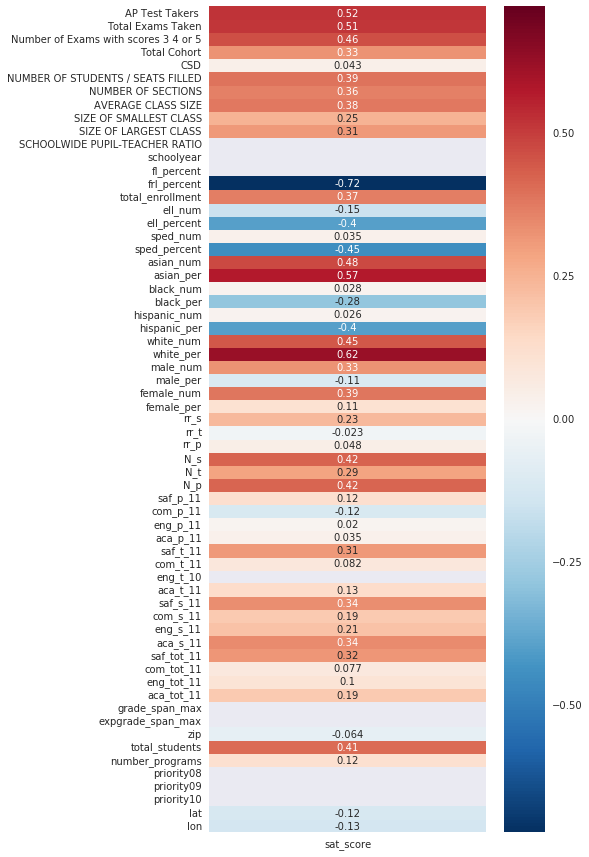

In [180]:
%matplotlib inline
import seaborn as sns

corr = combined.corr(method='pearson')[4:]
ylabels = list(corr.index)
corr = corr['sat_score'].reshape(63,1)

f, ax = plt.subplots(figsize=(8, 12))
ax = sns.heatmap(corr, annot=True, yticklabels=ylabels, xticklabels=['sat_score'])

f.tight_layout()


The values that were the most positively correlated with sat_scores (> 0.40) were: 
* AP Test Takers 
* Total Exams Taken
* N_s (number of survey respondents - students)
* N_p (number of survey respondents - parents)
* total_students
* Number of Exams with scores 3 4 or 5
* asian_num 
* asian_per
* white_num
* white_per


On the other side, the values with the greatest negative correlation (> -0.40) were:
* frl_percent (Percent of students on free/reduced lunch program)
* sped_percent (Percent of special education students)
* ell_percent (Percent of English language learners)
* hispanic_per (Percent of hispanic students)

While some of the SAT scores can be explained by students coming from educationally disadvantaged backgrounds (that is, ESL students and special education students) it appears there may be great effects from the institutional backgrounds of the schools given the racial and socioeconomic relationships with SAT scores. 

# Plot Schools on a map
Another moderately strong correlation found with SAT score results was the safety and respect scores reported by students(saf_s_11) and teachers(saf_s_11). To see if there is any relationship between these scores and location within New York City, the schools will be grouped by their district numbers, have their total safety and respect scores (saf_tot_11) averaged, and be plotted using Basemap.

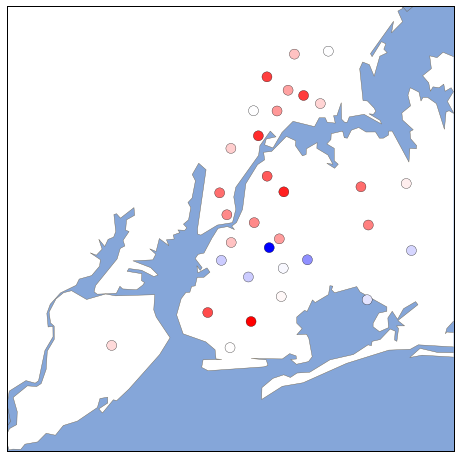

In [181]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

districts = combined.groupby("school_dist").agg(numpy.mean)
districts.reset_index(inplace=True)                
                  
fig = plt.figure(figsize=(8,8))

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='h'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='white',lake_color='#85A6D9')

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s=100, zorder=2, latlon=True, c=districts["saf_tot_11"], cmap="bwr")
plt.show()


The dots are colored on a grade with the dots representing the districts with the lowest reported safety and respect scores being colored blue and the highest being colored red. It appears that most districts are a shade of red which suggests that there is an unequal distribution of safety scores. To explore this, the report scores will be plotted on a bell curve.

Range: 1.525
STD: 0.32
Mean: 7.28


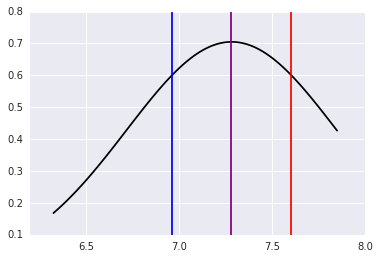

In [182]:
import matplotlib.mlab as mlab
import math

print('Range: ' + str(max(districts.saf_tot_11) - (min(districts.saf_tot_11))))
print('STD: ' + str(round(np.std(districts.saf_tot_11),2)))
print('Mean: ' + str(round(np.mean(districts.saf_tot_11),2)))

mu = (np.mean(districts.saf_tot_11))
sigma = math.sqrt(np.std(districts.saf_tot_11))
x = np.linspace(min(districts.saf_tot_11), max(districts.saf_tot_11), 100)

plt.plot(x,mlab.normpdf(x, mu, sigma), c='k')
plt.axvline(x=7.28, c='purple')
upper_std = 7.28+0.32
lower_std = 7.28-0.32
plt.axvline(x=lower_std, c='b')
plt.axvline(x=upper_std, c='r')
plt.show()

The blue and red lines represent one standard devation in both directions from the mean. It is clear that there is a negative skew to this graph which would explain the shading on our map.

The guided project had concluded by this point. Some further points of interest would be to analyze New York census data to explore reasons for the difference and skewness of reported safety scores. It would also be interesting to create another map with the dots shaded according to the correlations between safety scores and SAT results. 